# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [171]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [172]:
# UNCOMMENT IF USING COLAB
from google.colab import drive
import requests
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir) 
os.chdir(notebook_dir)
symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
r_s = requests.get(symco, allow_redirects=True)
r_c = requests.get(crpt, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)
with open('carpet.py', 'wb') as f:
    f.write(r_c.content)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [174]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [175]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Convolushahr


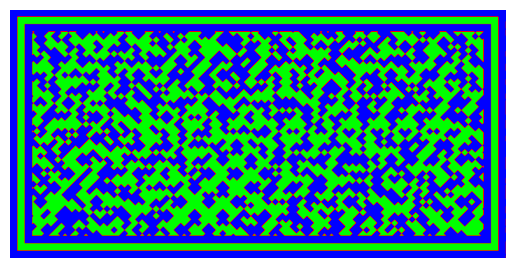

In [176]:
# # random carpet
# idx = np.random.randint(0,7500)
# show_carpet(X_train, idx)
# print('Carpet from', oh_to_label(y_train[idx,None])[0])
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [177]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

In [178]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [179]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    
    output=model(xb)
    loss = loss_func(output, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    _, preds = torch.max(output, 1)
    # _, preds = torch.amax(output, 2)
    # corrects = torch.sum(preds == yb.data)
    corrects = torch.sum(preds == torch.argmax(yb, dim=1))
    
    return loss.item(), corrects, len(xb)

In [180]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

   

In [181]:
from torch.utils.data import DataLoader
def get_data(train_ds, valid_ds, test_dataset, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=True),
        DataLoader(valid_ds, batch_size=bs * 2, drop_last=True),
        DataLoader(test_dataset, batch_size=bs, drop_last=True)
    )

In [182]:
bs=32

In [183]:
def preprocess(x, y):
    return x.to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl, test_dl = get_data(train_dataset, val_dataset, test_dataset, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

In [184]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dl))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 1, 96, 60]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32, 3])


In [185]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [188]:
model = nn.Sequential(
  sc.Slice(rotation=4, reflection=True),
  sc.SymmetryConv2d(in_filters=1,out_filters=16,kernel_size=4,rotation=4, stride=4, reflection = True),
  nn.ReLU(),
  nn.Dropout(p=0.2),
  sc.SymmetryPool(),
  Lambda(lambda x: x.view(x.size(0), -1)),
  nn.Linear(5760, 512),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.2),
  nn.Linear(512, 3)
)

In [189]:
#@title Standaard titeltekst
# model = nn.Sequential(
#   nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
#   nn.BatchNorm2d(32),
#   nn.ReLU(inplace=True),
#   nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#   nn.ReLU(inplace=True),
#   nn.MaxPool2d(kernel_size=2, stride=2),

#   # Conv Layer block 2
#   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#   nn.BatchNorm2d(64),
#   nn.ReLU(inplace=True),
#   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#   nn.ReLU(inplace=True),
#   nn.MaxPool2d(kernel_size=2, stride=2),


#   # Conv Layer block 3
#   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#   nn.BatchNorm2d(64),
#   nn.ReLU(inplace=True),
#   nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#   nn.ReLU(inplace=True),

#   Lambda(lambda x: x.view(x.size(0), -1)),

#   nn.Linear(23040, 1024),
#   nn.ReLU(inplace=True),
#   nn.Linear(1024, 512),
#   nn.ReLU(inplace=True),
#   nn.Linear(512, 3)
# )

In [190]:
from torch import optim
import torch.nn.functional as F

model.to(dev)
lr = 0.0001
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs=50
loss_func = F.cross_entropy

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

  2%|▏         | 1/50 [00:01<01:05,  1.33s/it]

EPOCH: 01/50 LOSS: 1.1506 ACC: 0.3387  VAL-LOSS: 1.0869 VAL-ACC: 0.4002 


  4%|▍         | 2/50 [00:02<01:03,  1.31s/it]

EPOCH: 02/50 LOSS: 1.0917 ACC: 0.3806  VAL-LOSS: 1.0792 VAL-ACC: 0.4400 


  6%|▌         | 3/50 [00:03<01:01,  1.30s/it]

EPOCH: 03/50 LOSS: 1.0758 ACC: 0.4128  VAL-LOSS: 1.0729 VAL-ACC: 0.3891 


  8%|▊         | 4/50 [00:05<00:59,  1.29s/it]

EPOCH: 04/50 LOSS: 1.0612 ACC: 0.4364  VAL-LOSS: 1.0636 VAL-ACC: 0.4274 


 10%|█         | 5/50 [00:06<00:57,  1.28s/it]

EPOCH: 05/50 LOSS: 1.0377 ACC: 0.4814  VAL-LOSS: 1.0329 VAL-ACC: 0.5423 


 12%|█▏        | 6/50 [00:08<01:01,  1.41s/it]

EPOCH: 06/50 LOSS: 1.0106 ACC: 0.5134  VAL-LOSS: 1.0071 VAL-ACC: 0.5449 


 14%|█▍        | 7/50 [00:09<01:04,  1.49s/it]

EPOCH: 07/50 LOSS: 0.9754 ACC: 0.5600  VAL-LOSS: 0.9899 VAL-ACC: 0.5862 


 16%|█▌        | 8/50 [00:11<01:00,  1.44s/it]

EPOCH: 08/50 LOSS: 0.9412 ACC: 0.5851  VAL-LOSS: 0.9494 VAL-ACC: 0.6462 


 18%|█▊        | 9/50 [00:12<00:56,  1.38s/it]

EPOCH: 09/50 LOSS: 0.8946 ACC: 0.6373  VAL-LOSS: 0.9108 VAL-ACC: 0.6305 


 20%|██        | 10/50 [00:14<00:58,  1.47s/it]

EPOCH: 10/50 LOSS: 0.8380 ACC: 0.6922  VAL-LOSS: 0.8545 VAL-ACC: 0.7147 


 22%|██▏       | 11/50 [00:15<00:59,  1.53s/it]

EPOCH: 11/50 LOSS: 0.7799 ACC: 0.7370  VAL-LOSS: 0.7983 VAL-ACC: 0.7500 


 24%|██▍       | 12/50 [00:17<00:56,  1.48s/it]

EPOCH: 12/50 LOSS: 0.7319 ACC: 0.7508  VAL-LOSS: 0.7342 VAL-ACC: 0.8085 


 26%|██▌       | 13/50 [00:18<00:52,  1.41s/it]

EPOCH: 13/50 LOSS: 0.6651 ACC: 0.8002  VAL-LOSS: 0.6948 VAL-ACC: 0.8367 


 28%|██▊       | 14/50 [00:19<00:48,  1.35s/it]

EPOCH: 14/50 LOSS: 0.6058 ACC: 0.8283  VAL-LOSS: 0.6263 VAL-ACC: 0.8710 


 30%|███       | 15/50 [00:20<00:48,  1.39s/it]

EPOCH: 15/50 LOSS: 0.5435 ACC: 0.8582  VAL-LOSS: 0.5650 VAL-ACC: 0.9068 


 32%|███▏      | 16/50 [00:22<00:49,  1.45s/it]

EPOCH: 16/50 LOSS: 0.4842 ACC: 0.8831  VAL-LOSS: 0.5240 VAL-ACC: 0.8846 


 34%|███▍      | 17/50 [00:23<00:47,  1.44s/it]

EPOCH: 17/50 LOSS: 0.4403 ACC: 0.9016  VAL-LOSS: 0.4945 VAL-ACC: 0.9199 


 36%|███▌      | 18/50 [00:25<00:44,  1.38s/it]

EPOCH: 18/50 LOSS: 0.3965 ACC: 0.9173  VAL-LOSS: 0.4440 VAL-ACC: 0.9093 


 38%|███▊      | 19/50 [00:26<00:41,  1.34s/it]

EPOCH: 19/50 LOSS: 0.3560 ACC: 0.9248  VAL-LOSS: 0.4392 VAL-ACC: 0.8997 


 40%|████      | 20/50 [00:27<00:39,  1.30s/it]

EPOCH: 20/50 LOSS: 0.3173 ACC: 0.9467  VAL-LOSS: 0.3665 VAL-ACC: 0.9526 


 42%|████▏     | 21/50 [00:28<00:37,  1.28s/it]

EPOCH: 21/50 LOSS: 0.2913 ACC: 0.9534  VAL-LOSS: 0.3299 VAL-ACC: 0.9622 


 44%|████▍     | 22/50 [00:30<00:35,  1.26s/it]

EPOCH: 22/50 LOSS: 0.2640 ACC: 0.9569  VAL-LOSS: 0.3125 VAL-ACC: 0.9688 


 46%|████▌     | 23/50 [00:31<00:33,  1.25s/it]

EPOCH: 23/50 LOSS: 0.2399 ACC: 0.9631  VAL-LOSS: 0.3640 VAL-ACC: 0.8649 


 48%|████▊     | 24/50 [00:32<00:32,  1.25s/it]

EPOCH: 24/50 LOSS: 0.2130 ACC: 0.9674  VAL-LOSS: 0.2689 VAL-ACC: 0.9824 


 50%|█████     | 25/50 [00:33<00:32,  1.29s/it]

EPOCH: 25/50 LOSS: 0.1885 ACC: 0.9825  VAL-LOSS: 0.2412 VAL-ACC: 0.9824 


 52%|█████▏    | 26/50 [00:35<00:33,  1.38s/it]

EPOCH: 26/50 LOSS: 0.1736 ACC: 0.9824  VAL-LOSS: 0.2277 VAL-ACC: 0.9839 


 54%|█████▍    | 27/50 [00:37<00:32,  1.41s/it]

EPOCH: 27/50 LOSS: 0.1616 ACC: 0.9809  VAL-LOSS: 0.2189 VAL-ACC: 0.9884 


 56%|█████▌    | 28/50 [00:38<00:29,  1.35s/it]

EPOCH: 28/50 LOSS: 0.1472 ACC: 0.9862  VAL-LOSS: 0.1954 VAL-ACC: 0.9899 


 58%|█████▊    | 29/50 [00:39<00:27,  1.31s/it]

EPOCH: 29/50 LOSS: 0.1369 ACC: 0.9880  VAL-LOSS: 0.1869 VAL-ACC: 0.9854 


 60%|██████    | 30/50 [00:40<00:25,  1.28s/it]

EPOCH: 30/50 LOSS: 0.1301 ACC: 0.9892  VAL-LOSS: 0.1715 VAL-ACC: 0.9879 


 62%|██████▏   | 31/50 [00:41<00:24,  1.27s/it]

EPOCH: 31/50 LOSS: 0.1194 ACC: 0.9892  VAL-LOSS: 0.1635 VAL-ACC: 0.9914 


 64%|██████▍   | 32/50 [00:43<00:22,  1.25s/it]

EPOCH: 32/50 LOSS: 0.1111 ACC: 0.9924  VAL-LOSS: 0.1539 VAL-ACC: 0.9914 


 66%|██████▌   | 33/50 [00:44<00:21,  1.24s/it]

EPOCH: 33/50 LOSS: 0.1054 ACC: 0.9915  VAL-LOSS: 0.1458 VAL-ACC: 0.9934 


 68%|██████▊   | 34/50 [00:45<00:19,  1.24s/it]

EPOCH: 34/50 LOSS: 0.0950 ACC: 0.9939  VAL-LOSS: 0.1437 VAL-ACC: 0.9884 


 70%|███████   | 35/50 [00:46<00:18,  1.24s/it]

EPOCH: 35/50 LOSS: 0.0907 ACC: 0.9953  VAL-LOSS: 0.1349 VAL-ACC: 0.9955 


 72%|███████▏  | 36/50 [00:48<00:18,  1.33s/it]

EPOCH: 36/50 LOSS: 0.0836 ACC: 0.9948  VAL-LOSS: 0.1248 VAL-ACC: 0.9950 


 74%|███████▍  | 37/50 [00:49<00:18,  1.40s/it]

EPOCH: 37/50 LOSS: 0.0755 ACC: 0.9964  VAL-LOSS: 0.1208 VAL-ACC: 0.9914 


 76%|███████▌  | 38/50 [00:51<00:16,  1.36s/it]

EPOCH: 38/50 LOSS: 0.0759 ACC: 0.9967  VAL-LOSS: 0.1354 VAL-ACC: 0.9824 


 78%|███████▊  | 39/50 [00:52<00:14,  1.30s/it]

EPOCH: 39/50 LOSS: 0.0725 ACC: 0.9960  VAL-LOSS: 0.1129 VAL-ACC: 0.9970 


 80%|████████  | 40/50 [00:53<00:12,  1.27s/it]

EPOCH: 40/50 LOSS: 0.0673 ACC: 0.9976  VAL-LOSS: 0.1038 VAL-ACC: 0.9934 


 82%|████████▏ | 41/50 [00:55<00:12,  1.35s/it]

EPOCH: 41/50 LOSS: 0.0620 ACC: 0.9972  VAL-LOSS: 0.1224 VAL-ACC: 0.9919 


 84%|████████▍ | 42/50 [00:56<00:10,  1.36s/it]

EPOCH: 42/50 LOSS: 0.0609 ACC: 0.9977  VAL-LOSS: 0.1049 VAL-ACC: 0.9929 


 86%|████████▌ | 43/50 [00:57<00:09,  1.32s/it]

EPOCH: 43/50 LOSS: 0.0563 ACC: 0.9984  VAL-LOSS: 0.0980 VAL-ACC: 0.9960 


 88%|████████▊ | 44/50 [00:58<00:07,  1.29s/it]

EPOCH: 44/50 LOSS: 0.0550 ACC: 0.9973  VAL-LOSS: 0.0921 VAL-ACC: 0.9955 


 90%|█████████ | 45/50 [01:00<00:06,  1.28s/it]

EPOCH: 45/50 LOSS: 0.0519 ACC: 0.9987  VAL-LOSS: 0.0987 VAL-ACC: 0.9899 


 92%|█████████▏| 46/50 [01:01<00:05,  1.36s/it]

EPOCH: 46/50 LOSS: 0.0488 ACC: 0.9984  VAL-LOSS: 0.0983 VAL-ACC: 0.9904 


 94%|█████████▍| 47/50 [01:03<00:04,  1.42s/it]

EPOCH: 47/50 LOSS: 0.0493 ACC: 0.9977  VAL-LOSS: 0.0897 VAL-ACC: 0.9924 


 96%|█████████▌| 48/50 [01:04<00:02,  1.37s/it]

EPOCH: 48/50 LOSS: 0.0457 ACC: 0.9987  VAL-LOSS: 0.0808 VAL-ACC: 0.9960 


 98%|█████████▊| 49/50 [01:05<00:01,  1.32s/it]

EPOCH: 49/50 LOSS: 0.0416 ACC: 0.9988  VAL-LOSS: 0.0798 VAL-ACC: 0.9970 


100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

EPOCH: 50/50 LOSS: 0.0419 ACC: 0.9989  VAL-LOSS: 0.0796 VAL-ACC: 0.9945 


In [191]:
from tqdm import tqdm
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    for epoch in tqdm(range(epochs)):
        
        
        # training process
        model.train()

        running_loss = 0.0
        running_corrects = 0
        sample_num=0
        for xb, yb in train_dl:
            
            # forward
            # backward and optimize only if in training phase
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb,opt)
            
            # statistics
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num+=nums
            
        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        
        # validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in valid_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double()/ sample_num
            
            
        # print the results
        print(
            f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}',
            end=' '
        )
        print(f'LOSS: {train_loss:.4f}',f'ACC: {train_acc:.4f} ',end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}',f'VAL-ACC: {val_acc:.4f} ',end='\n')

   

In [198]:

def test(model, loss_func, opt, test_dl):

        # test process
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num=0
            for xb, yb in test_dl:
                
                # forward
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                
                # statistics
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num+=nums

            test_acc = running_corrects.double()/ sample_num
            
            
        print(f'TEST-ACC: {test_acc:.4f} ',end='\n')

   

In [199]:
test(model, loss_func, opt, test_dl)


TEST-ACC: 0.9958 


## Task 1: Question 5d

# Task 2: Carpet Matching 

In [194]:
#@title Standaard titeltekst
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [195]:
#@title Standaard titeltekst
# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):

        q = queries[i][None].float().cuda()
        t = targets[i].float().cuda()

        with torch.no_grad():
            
            
            ### MODIFY IF NECESSARY ###
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)
            
            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0,:top].tolist():
                    cnt+=1
    return (100*cnt/gt.shape[0])

In [196]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###